# Synthesis of Bennett Mechanism (JupyterNTB Tutorial)

This Jupyter notebook serves as an example of using the package for mechanism synthesis. Run it live on Binder platform clicking on the following badge: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hucik14/rl-issues/HEAD?labpath=jupyter_ntbs%2Fsynthesis_bennett.ipynb)

In [1]:
# in case of errors, make sure to have the latest version of the rational-linkages package installed (uncomment the following line and run the cell)
# !pip install --upgrade rational-linkages

In [2]:
# initial import of the required libraries
%matplotlib inline
import numpy as np

from rational_linkages import (DualQuaternion, Plotter, MotionInterpolation, 
                               TransfMatrix, RationalMechanism)

## Poses definition

Bennett mechanism can be synthesised from a quadratic motion curve. This curve can be obtained from interpolation of 3 given poses. Poses can be defined as transformation matrices or dual quaternions. This examples creates poses from roll, pitch, yaw angles and desired translations.

In [3]:
p0 = TransfMatrix.from_rpy_xyz([-40, 0, 0], [0.030, 0.1, 0.02], unit='deg')  
p1 = TransfMatrix.from_rpy_xyz([0, 90, 0], [0.09, -0.05, -0.02], unit='deg')  
p2 = TransfMatrix()  # for simplification, p2 is the identity matrix

poses = [p0, p1, p2]  # list of the transformation matrices

for i, pose in enumerate(poses):
    print(f'Pose {i}:')
    print(pose)
    

Pose 0:
[[ 1.          ,  0.          ,  0.          ,  0.          ],
 [ 0.03        ,  1.          ,  0.          ,  0.          ],
 [ 0.1         ,  0.          ,  0.7660444431,  0.6427876097],
 [ 0.02        ,  0.          , -0.6427876097,  0.7660444431]]
Pose 1:
[[ 1.  ,  0.  ,  0.  ,  0.  ],
 [ 0.09,  0.  ,  0.  ,  1.  ],
 [-0.05,  0.  ,  1.  ,  0.  ],
 [-0.02, -1.  ,  0.  ,  0.  ]]
Pose 2:
[[1., 0., 0., 0.],
 [0., 1., 0., 0.],
 [0., 0., 1., 0.],
 [0., 0., 0., 1.]]


You can notice that the matrices follow "european" convetion, i.e. the first row are homogeneous coordinates, the first column is the translation vector, and rotation matrix is in the second to last column/row.

We chose p2 to be identity matrix, which returns monomial curve. This means, that the curve will interpolate exactly the desired poses. This pose can be arbitrary, but since the factorization produces later monomial polynoms, the whole mechanism will undergo static transformation by p2.

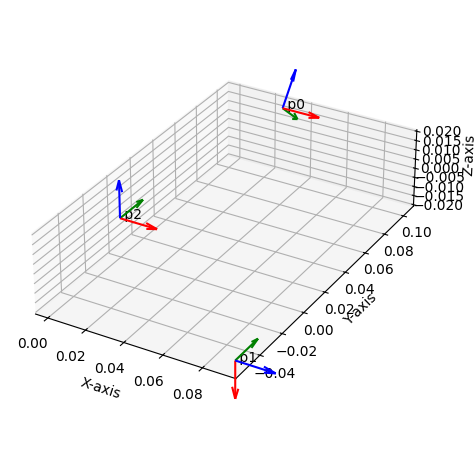

In [4]:
# initiate plotter
myplt = Plotter(interactive=False, jupyter_notebook=True, arrows_length=0.02)
for i, pose in enumerate(poses):
    myplt.plot(pose, label=f'p{i}')

## Poses interpolation


Interpolated curve:
RationalCurve([20.8081075278796*t**2 - 27.9663655927283*t + 9.15825806484875, 3.33333333333333*t - 3.33333333333333, 2.0*t, 0, -0.0500000000000000, 0.0273738709727313*t - 0.137373870972731, 0.474579569909104*t - 0.424579569909104, 0.188249247315154*t - 0.258249247315154])


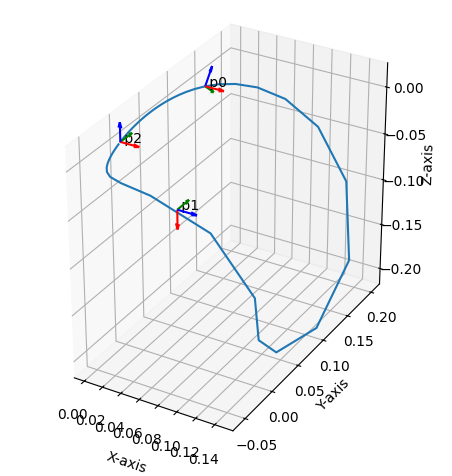

In [5]:
# obtain curve from poses
curve = MotionInterpolation.interpolate(poses)

print('')
print('Interpolated curve:')
print(curve)

myplt = Plotter(interactive=False, jupyter_notebook=True, arrows_length=0.02)
for i, pose in enumerate(poses):
    myplt.plot(pose, label=f'p{i}')
myplt.plot(curve, interval='closed', label='Interpolated curve')

Keep in mind, that the curve above is 8-dimensional curve that interpolates both, position and orientation. The plotted blue curve shows only position.

## Motion factorization

Synthesize mechanism that can follow given motion curve

Factorization is running...
Factorization ended.


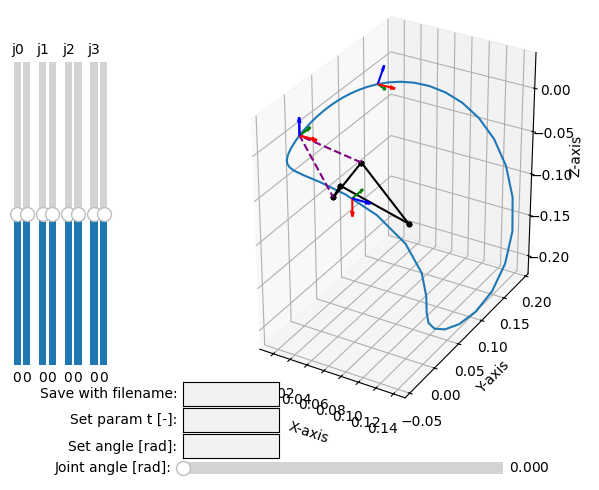

In [6]:
mechanism = RationalMechanism(curve.factorize())

myplt = Plotter(interactive=True, jupyter_notebook=True, arrows_length=0.02)
for i, pose in enumerate(poses):
    myplt.plot(pose)
myplt.plot(mechanism, show_tool=True)

On the figure above, a Bennett mechanism (black) that can achieve with its tool frame (tool link is represented with purple dashed lines) is shown. This only very simple line model with collisions, which can be checked using following line.

In [7]:
mechanism.collision_check()

Collision check started...
--- number of tasks to solve: 21 ---
--- collision check finished in 10.650903701782227 seconds.
The linkage is colliding 2 times at the following parameter values:
3.812435824225698
0.5912946323469377


[3.812435824225698, 0.5912946323469377]

## Collision-free design

It is possible to run collision-free linkage using the combinatorial search algorithm. Since it is a time demanding task, the following line is commented.

In [8]:
# mechanism.collision_free_optimization(max_iters=10)

A solution was already calculated before for following shifts of combinations. Lists of combinations can be also inserted in to the search, the same as starting iteration, etc. Please, read more carefully the tutorial documentation page on this topic.

Starting combinatorial search algorithm...
--- iteration: 1, shift_value: 0.01202269508561866, sequence 1 of 1: (0, 0, 0, 1)
Collision check started...
--- number of tasks to solve: 2 ---
--- collision check finished in 2.1132309436798096 seconds.
No collisions found.

Collision-free solution for links found, starting joint search...
--- joint search. Shift_value: 0.0015, sequence 1 of 1: (1, -1, -1, 1, -1, 1, 1, -1)
Collision check started...
--- number of tasks to solve: 21 ---
--- collision check finished in 11.139376640319824 seconds.
No collisions found.
Search was successful, collision-free solution found.


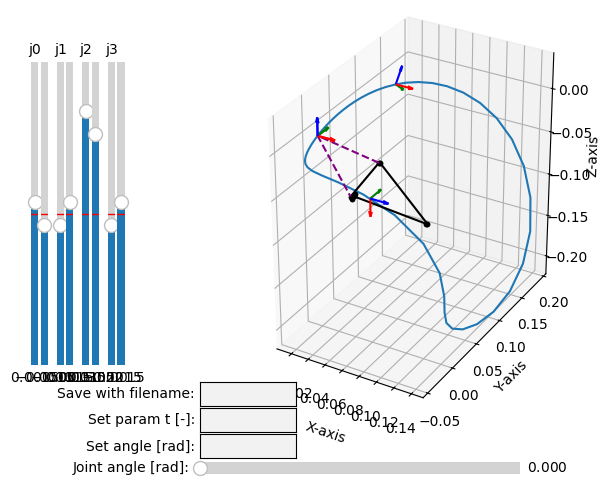

In [9]:
comb_links = [(0, 0, 0, 1)]
comb_joints = [(1, -1, -1, 1, -1, 1, 1, -1)]
mechanism.collision_free_optimization(min_joint_segment_length=0.003,
                                       combinations_links=comb_links,
                                       combinations_joints=comb_joints)

myplt = Plotter(interactive=True, jupyter_notebook=True, arrows_length=0.02, joint_range_lim=0.02, )
for i, pose in enumerate(poses):
    myplt.plot(pose)
myplt.plot(mechanism, show_tool=True)

The animated mechanism can be seen on the GIF bellow.

![Mechanism](figures/mech_quadratic.gif "Mechanism")

## Generation of phsycical parameters

The following line can obtains Denavit-Hartenberg paramaters and joint connection parameters for pre-prepared CAD models. The scale=1000 argument scales the lenght by 1000 units to change from meters to milimeters. 

In [10]:
design_parameters = mechanism.get_design(scale=1000, unit='deg')

---
Link 0: d = -27.147454, a = 68.274374, alpha = 128.164082
cp_0 = -57.576756, cp_1 = 102.707190
---
Link 1: d = 0.000000, a = 82.009314, alpha = 109.193213
cp_0 = 123.707190, cp_1 = 33.675053
---
Link 2: d = -0.000000, a = 68.274374, alpha = 128.164082
cp_0 = 12.675053, cp_1 = 15.952730
---
Link 3: d = -0.000000, a = 82.009314, alpha = 109.193213
cp_0 = 36.952730, cp_1 = -9.429302


The parameters above can be inserted in your copies of the prepared models on OnShape platform - follow the related manual on this documentation webpage:
https://rational-linkages.readthedocs.io/latest/tutorials/ark2024.html#physical-modelling-of-bennett-mechanism

